In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM

### Load data

In [2]:
fp_data = "/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/20191117_aSi_200kV_ca0p51_cl300_30x30_5nmstep_exp0p1.dm4"
fp_vac = "/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/20191117_aSi_vac_200kV_ca0p51_cl300_12x12_5nmstep_exp0p01.dm4"

dc = py4DSTEM.file.io.read(fp_data)
dc_vac = py4DSTEM.file.io.read(fp_vac)

dc.set_scan_shape(30,30)
dc_vac.set_scan_shape(12,12)

dc.data = np.roll(dc.data,axis=1,shift=-2)

/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/20191117_aSi_200kV_ca0p51_cl300_30x30_5nmstep_exp0p1.dm4 is not a py4DSTEM file.
Reading with hyperspy...
/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/20191117_aSi_vac_200kV_ca0p51_cl300_12x12_5nmstep_exp0p01.dm4 is not a py4DSTEM file.
Reading with hyperspy...


### Vacuum probe

In [3]:
from py4DSTEM.process.braggdiskdetection import get_average_probe_from_vacuum_scan
from py4DSTEM.process.braggdiskdetection import get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM

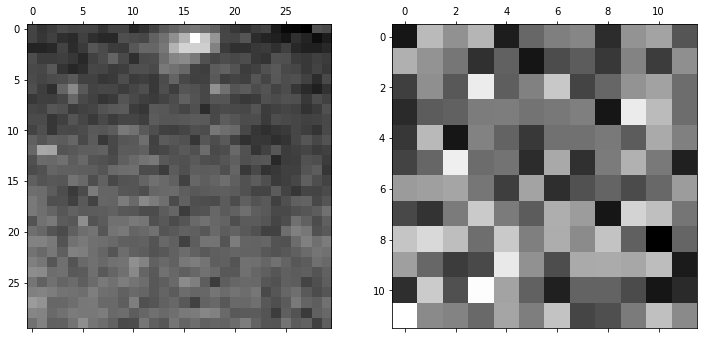

In [4]:
ave_im = np.mean(dc.data,axis=(2,3))
ave_im_vac = np.mean(dc_vac.data,axis=(2,3))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax2.matshow(ave_im_vac)
plt.show()

In [5]:
probe = get_average_probe_from_vacuum_scan(dc_vac)

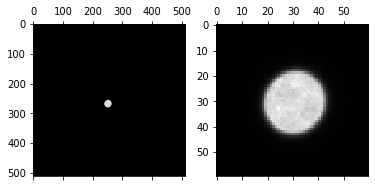

In [6]:
rad = 30

xCoM_pr,yCoM_pr = get_CoM(probe)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe,cmap='gray')
ax2.matshow(probe[int(xCoM_pr)-rad:int(xCoM_pr)+rad,int(yCoM_pr)-rad:int(yCoM_pr)+rad])
plt.show()

In [7]:
sigma_probe_scale=4

probe_kernel = get_probe_kernel_subtrgaussian(probe, sigma_probe_scale=sigma_probe_scale)

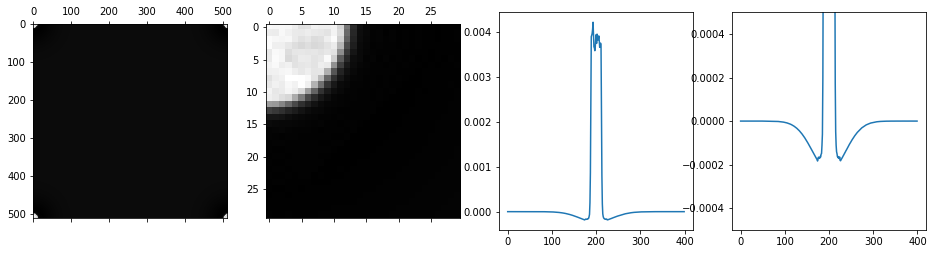

In [8]:
# Display probe_kernel, with line profile

rad=30
lineprofile_length=200
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),probe.shape)
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(16,4))
ax1.matshow(probe_kernel)
ax2.matshow(probe_kernel[:rad,:rad])
ax3.plot(np.arange(len(line_profile)),line_profile)
ax4.plot(np.arange(len(line_profile)),line_profile)
ax4.set_ylim(-0.0005,0.0005)
plt.show()

### Measure disk positions

In [9]:
from py4DSTEM.process.braggdiskdetection import find_Bragg_disks, find_Bragg_disks_selected, get_bragg_vector_map

Analyzed 3 diffraction patterns in 0h 0m 0s


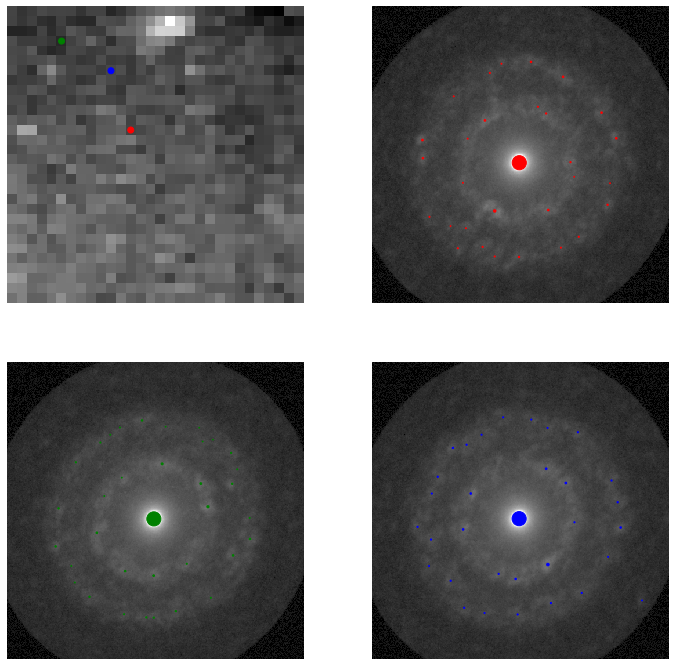

In [10]:
######## Parameters ########

# Select scan positions
Rxs = 12,3,6
Rys = 12,5,10

# Peak detection parameters
corrPower = 1
sigma = 2
edgeBoundary = 10
maxNumPeaks = 100
minPeakSpacing = 10
minRelativeIntensity = 0.1
relativeToPeak=1
subpixel = 'multicorr'
upsample_factor = 16

# Display parameters
power=0.3
size_scale_factor = 200       # Set to zero to make all points the same size

############################

# Find peaks
peaks = find_Bragg_disks_selected(dc, probe_kernel, Rxs, Rys,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  relativeToPeak=relativeToPeak,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel,
                                  upsample_factor=upsample_factor)

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(ave_im)
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

In [11]:
verbose = True

braggpeaks = find_Bragg_disks(dc, probe_kernel,
                              corrPower=corrPower,
                              sigma=sigma,
                              edgeBoundary=edgeBoundary,
                              minRelativeIntensity=minRelativeIntensity,
                              relativeToPeak=relativeToPeak,
                              minPeakSpacing=minPeakSpacing,
                              maxNumPeaks=maxNumPeaks,
                              subpixel=subpixel,
                              upsample_factor=upsample_factor,
                              verbose=verbose)
braggpeaks.name = 'braggpeaks'

Analyzing: |**************************************************| 100.0% Complete

Analyzed 900 diffraction patterns in 0h 1m 44s


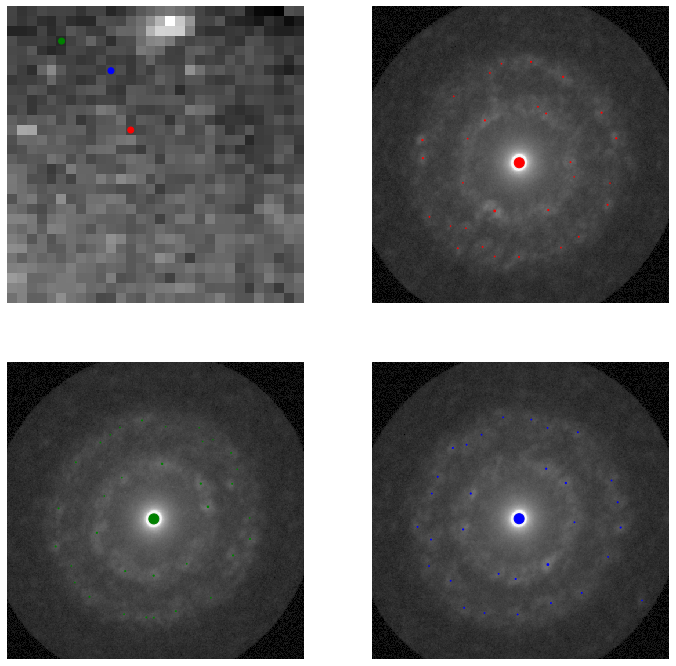

In [12]:
# Show results for a few DPs

Rxs = 12,3,6
Rys = 12,5,10
power = 0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(ave_im)
ax11.scatter(Rys,Rxs,color=('r','g','b'))

ax12.matshow(dc.data[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data[Rxs[2],Rys[2],:,:]**power)

peaks0 = braggpeaks.get_pointlist(Rxs[0],Rys[0])
peaks1 = braggpeaks.get_pointlist(Rxs[1],Rys[1])
peaks2 = braggpeaks.get_pointlist(Rxs[2],Rys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

In [13]:
# Get Bragg vector map

braggvectormap = get_bragg_vector_map(braggpeaks,dc.Q_Nx,dc.Q_Ny)

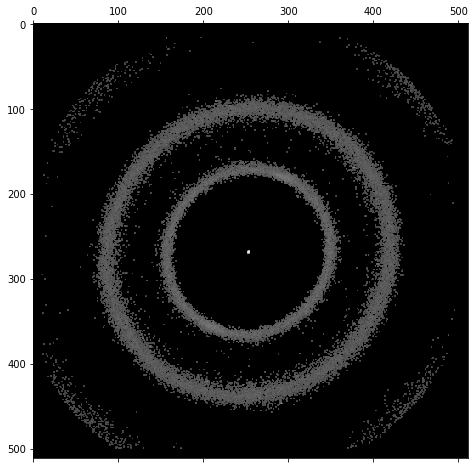

In [14]:
# Show

power = 0.1

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**power)
plt.show()

### Measure diffraction shifts

In [76]:
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts, shift_braggpeaks
from py4DSTEM.process.fit import fit_2D
from scipy.ndimage.filters import gaussian_filter

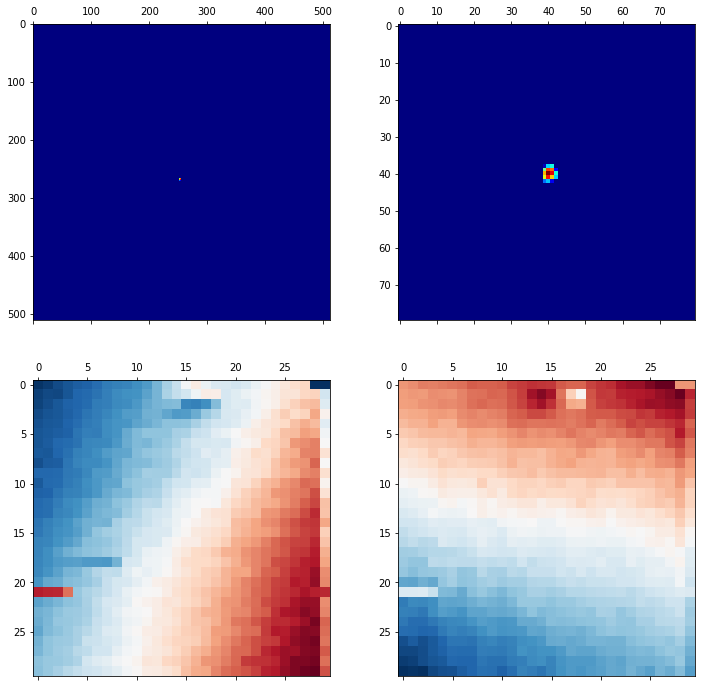

In [77]:
# Get diffraction shifts

findcenter = 'CoM'   # Must be 'CoM' or 'max'
rad = 40             # for display
power = 0.25

xshifts, yshifts, braggvectormap_center = get_diffraction_shifts(braggpeaks,
                                                                 dc.Q_Nx, dc.Q_Ny,
                                                                 findcenter=findcenter)

# Show
x0,y0 = py4DSTEM.process.utils.get_CoM(braggvectormap_center)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(braggvectormap_center**0.25,cmap='jet')
ax12.matshow(braggvectormap_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**power,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

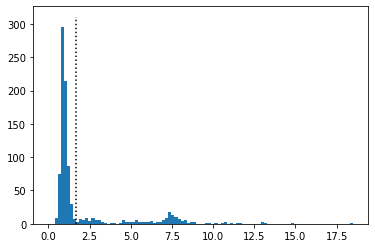

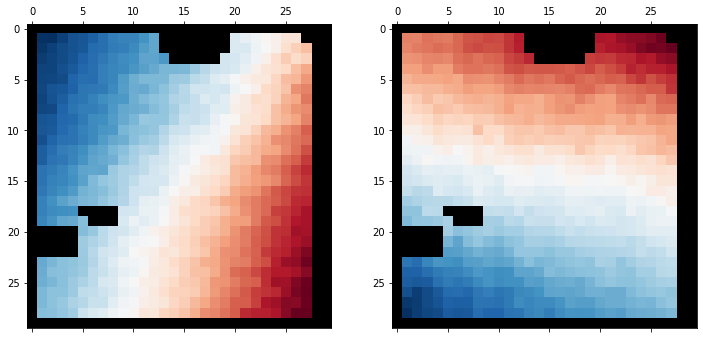

In [79]:
# Find outliers

n_sigma = 10
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = np.ma.masked_array(xshifts, mask)
yshifts_masked = np.ma.masked_array(yshifts, mask)
mask_display = np.ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

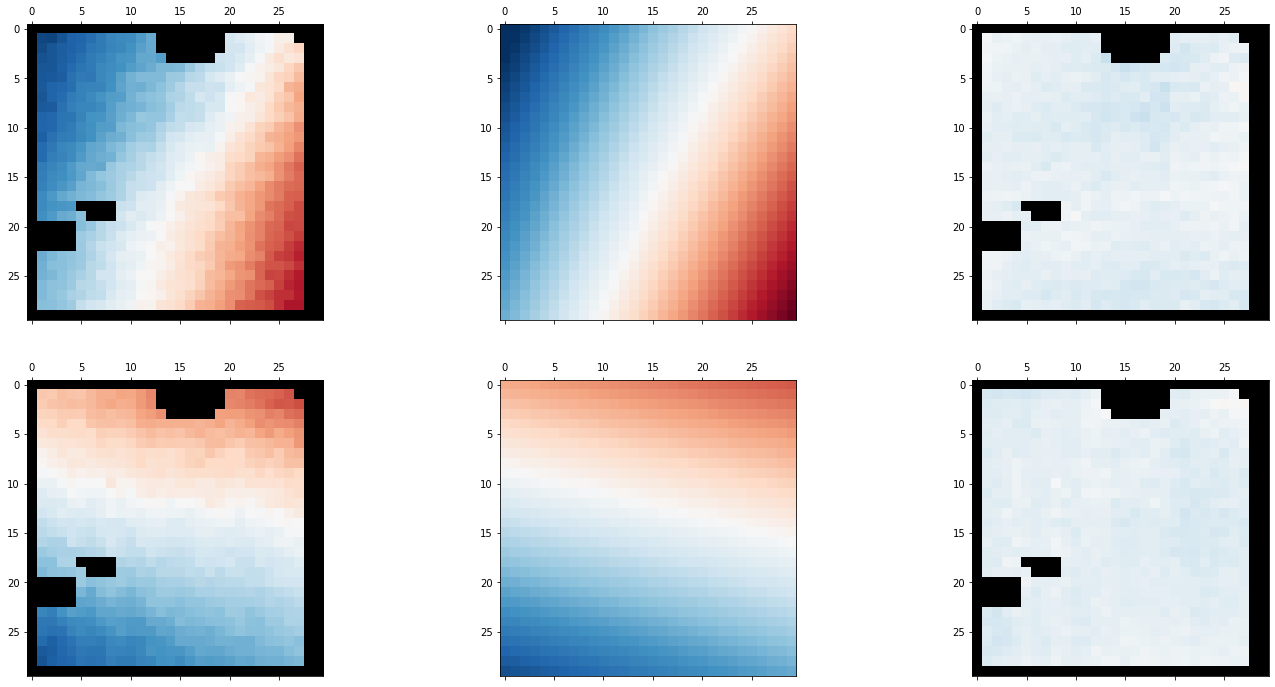

In [86]:
# Fit the diffraction shifts

#fit_function = py4DSTEM.process.fit.plane        # Select fit type
fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

vmin = min(np.min(xshifts),np.min(xshifts_fit))
vmax = min(np.max(xshifts),np.max(xshifts_fit))

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,12))
ax11.matshow(xshifts,cmap="RdBu",vmin=vmin,vmax=vmax)
ax21.matshow(yshifts,cmap="RdBu",vmin=vmin,vmax=vmax)
ax12.matshow(xshifts_fit,cmap="RdBu",vmin=vmin,vmax=vmax)
ax22.matshow(yshifts_fit,cmap="RdBu",vmin=vmin,vmax=vmax)
ax13.matshow(residuals_x,cmap="RdBu",vmin=vmin,vmax=vmax)
ax23.matshow(residuals_y,cmap="RdBu",vmin=vmin,vmax=vmax)
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

In [87]:
# Apply shifts

braggpeaks_shiftcorrected = shift_braggpeaks(braggpeaks, xshifts_fit, yshifts_fit)

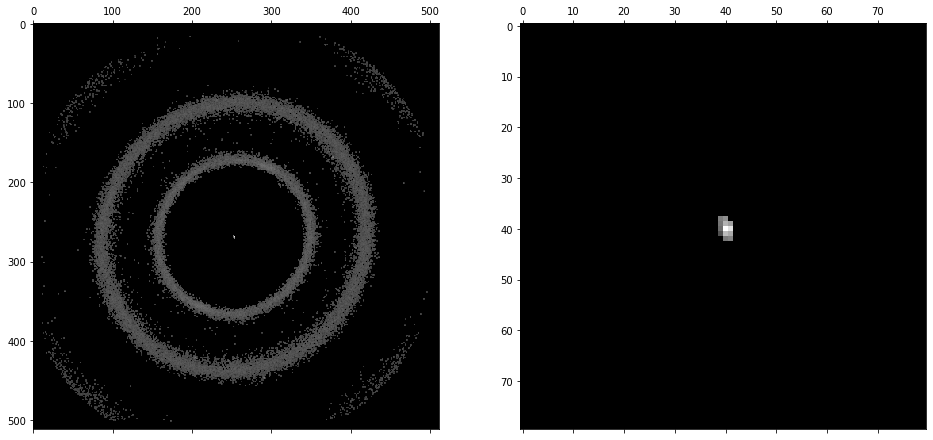

In [88]:
# Re-calculate Bragg vector map and show

braggvectormap_shiftcorrected = get_bragg_vector_map(braggpeaks_shiftcorrected,dc.Q_Nx,dc.Q_Ny)
power = 0.1

# Show
x0,y0=np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(braggvectormap_shiftcorrected**power)
ax2.matshow(braggvectormap_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad]**power)
plt.show()

### Average DP

In [89]:
from py4DSTEM.process.classification import get_class_DP

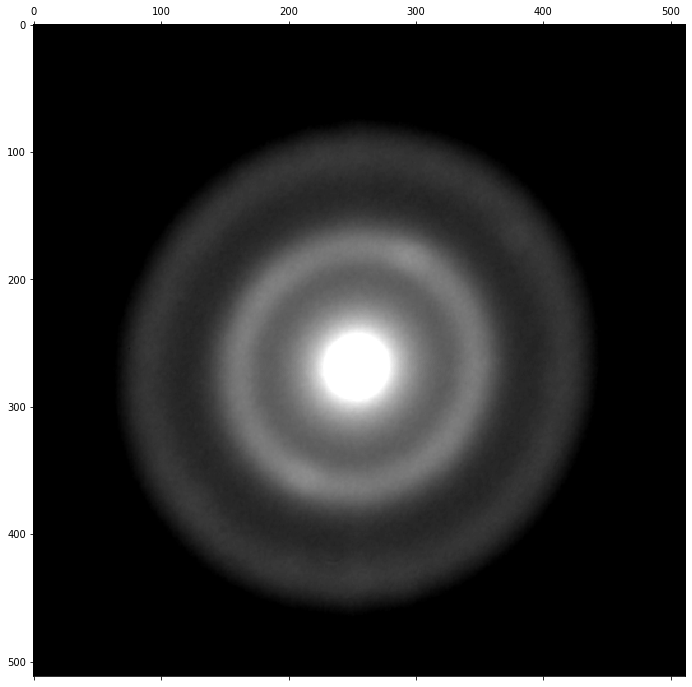

In [90]:
power = 0.2
nstd = 3

aveDP = get_class_DP(dc, np.ones((dc.R_Nx,dc.R_Ny)), xshifts=xshifts, yshifts=yshifts)

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(aveDP**power, vmin=np.mean(aveDP**power), vmax=np.mean(aveDP**power)+nstd*np.std(aveDP**power))
plt.show()

### Measure elliptical distortions
Fit 1D ellipse to bragg vector map

In [91]:
from matplotlib.patches import Circle, Ellipse
from py4DSTEM.process.utils import fit_ellipse_inside_annulus

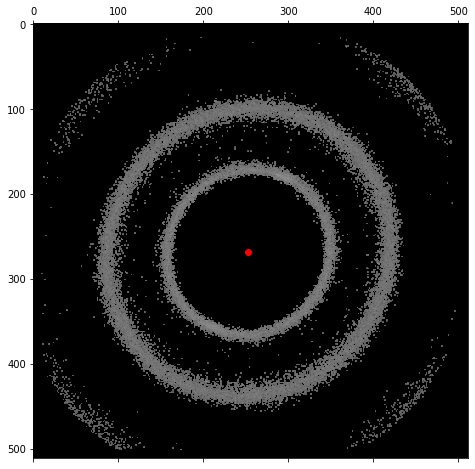

In [92]:
# Find center

power = 0.07

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(dc.Q_Nx,dc.Q_Ny))

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap_shiftcorrected**power)
ax.scatter(y0,x0,color='r')
plt.show()

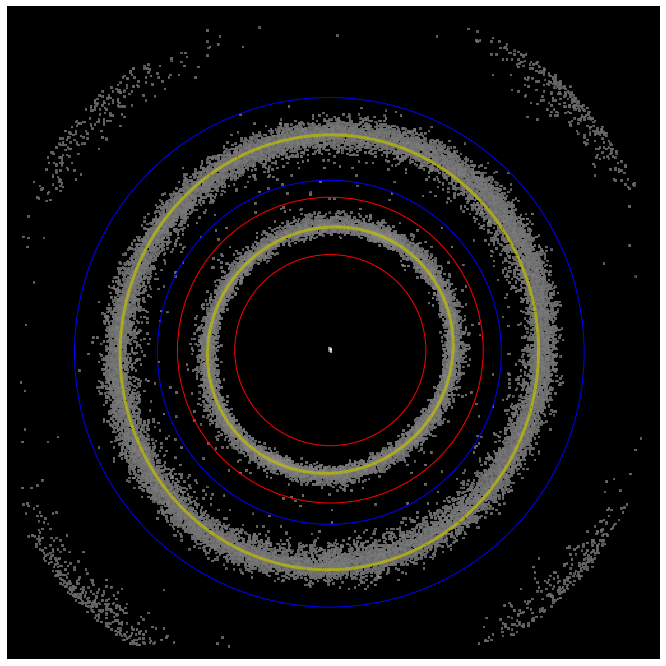

Measured elliptical stretch 1: 3.96
Measured elliptical stretch 2: 3.85


In [93]:
# Fit an ellipse

r_inner1 = 75
r_outer1 = 120
r_inner2 = 135
r_outer2 = 200

ellipse_params1 = fit_ellipse_inside_annulus(braggvectormap_shiftcorrected, x0, y0, r_inner1, r_outer1)
ellipse_params2 = fit_ellipse_inside_annulus(braggvectormap_shiftcorrected, x0, y0, r_inner2, r_outer2)
x0_1,y0_1,A_1,B_1,phi_1 = ellipse_params1
x0_2,y0_2,A_2,B_2,phi_2 = ellipse_params2

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_shiftcorrected**power)
circle_inner1 = Circle((y0_1,x0_1),radius=r_inner1, fill=False,edgecolor='r',linestyle="-")
circle_outer1 = Circle((y0_1,x0_1),radius=r_outer1, fill=False,edgecolor='r',linestyle="-")
circle_inner2 = Circle((y0_2,x0_2),radius=r_inner2, fill=False,edgecolor='b',linestyle="-")
circle_outer2 = Circle((y0_2,x0_2),radius=r_outer2, fill=False,edgecolor='b',linestyle="-")
ellipse1 = Ellipse((y0_1,x0_1),2*A_1,2*B_1,90-np.degrees(phi_1), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ellipse2 = Ellipse((y0_2,x0_2),2*A_2,2*B_2,90-np.degrees(phi_2), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner1)
ax.add_patch(circle_outer1)
ax.add_patch(circle_inner2)
ax.add_patch(circle_outer2)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.axis('off')
plt.show()

print("Measured elliptical stretch 1: {:.2f}".format(100*(1-B_1/A_1)))
print("Measured elliptical stretch 2: {:.2f}".format(100*(1-B_2/A_2)))

### Measure elliptical distortions 2
Fit double-sided gaussian to average DP

In [94]:
from matplotlib.patches import Circle, Ellipse
from py4DSTEM.process.utils import fit_double_sided_gaussian, convert_ellipse_params, double_sided_gaussian
from py4DSTEM.process.utils import radial_integral

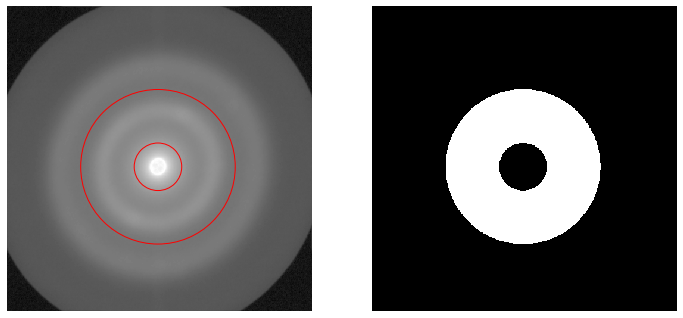

In [95]:
# Make a mask

# r_inner = 135
# r_outer = 200
r_inner = 40
r_outer = 130

yy,xx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
rr = np.hypot(xx-x0_1,yy-y0_1)
mask = (rr>r_inner)*(rr<=r_outer)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(aveDP**power)
circle_inner = Circle((y0_1,x0_1),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0_1,x0_1),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax1.add_patch(circle_inner)
ax1.add_patch(circle_outer)
ax2.matshow(mask)
ax1.axis('off')
ax2.axis('off')
plt.show()

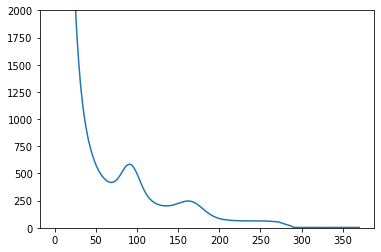

In [96]:
radial_profile = radial_integral(aveDP, x0_1,y0_1)[0]

fig,ax = plt.subplots()
ax.plot(np.arange(len(radial_profile)),radial_profile)
ax.set_ylim(0,2000)
plt.show()

In [97]:
# Fit a double-sided guassian

I0 = 10000
I1 = 700
sigma0 = 50
sigma1 = 20
sigma2 = 20
c_bkgd = 0
R = 95
x0 = x0_1
y0 = y0_1
A = 1
B = 0
C = 1

p0 = (I0,I1,sigma0,sigma1,sigma2,c_bkgd,R,x0,y0,A,B,C)
dsg_params = fit_double_sided_gaussian(aveDP, p0, mask=mask)

A,B,phi = convert_ellipse_params(dsg_params[9],dsg_params[10],dsg_params[11])
x0,y0 = dsg_params[7:9]
R = dsg_params[6]

/home/ben/Projects/py4DSTEM/py4DSTEM/py4DSTEM/process/utils/ellipticalCoords.py:313: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(r2)


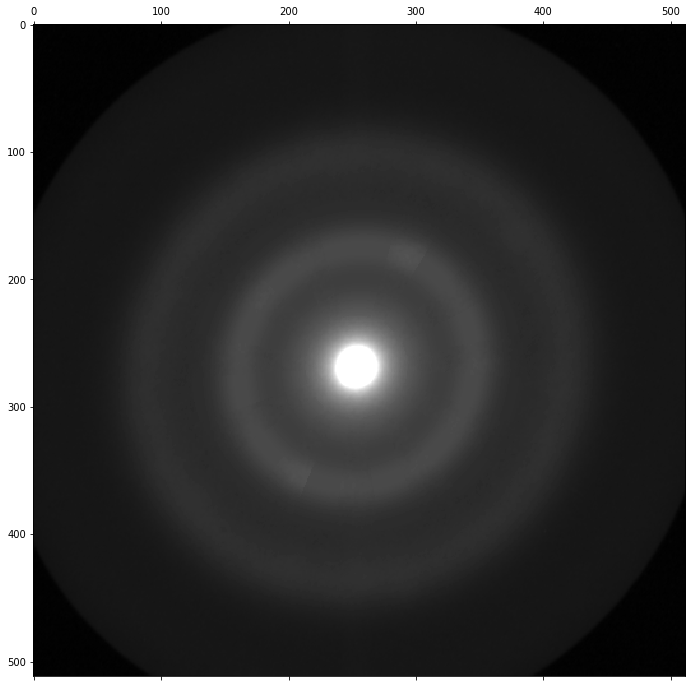

In [106]:
# display results
# colin-style visualization

power=0.5
# r_inner = 200
# r_outer = 350
N_pinwheel = 24  # Even number

# Make coords
yy,xx = np.meshgrid(np.arange(dc.Q_Nx),np.arange(dc.Q_Ny))
x,y = xx-x0,yy-y0
r = np.hypot(x,y)
r2 = r**2
theta = np.arctan2(y,x)

# Make mask
thetas = np.linspace(-np.pi,np.pi,N_pinwheel)
pinwheel = np.zeros((dc.Q_Nx,dc.Q_Ny))
for i in range(len(thetas[::2])):
    pinwheel += (theta<thetas[1::2][i]) * (theta>=thetas[::2][i])
mask = pinwheel * (r>r_inner) * (r<=r_outer)

# Get fit
fit = double_sided_gaussian(dsg_params,xx,yy)

data_ma = np.ma.array(data=aveDP, mask=mask)
fit_ma = np.ma.array(data=fit, mask=mask==False)

# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(data_ma**power,vmin=np.min(data_ma**power),vmax=0.6*np.max(data_ma**power))
ax.matshow(fit_ma**power,vmin=np.min(data_ma**power),vmax=0.6*np.max(data_ma**power))
plt.show()

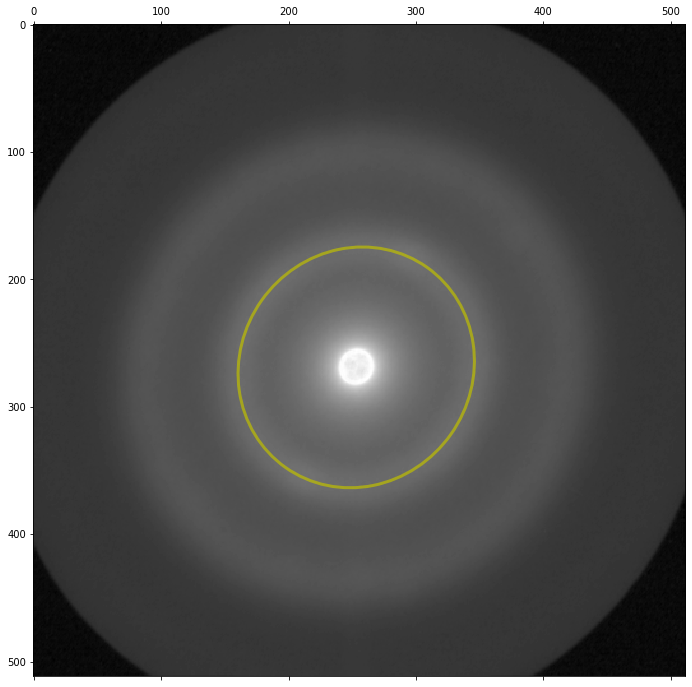

Measured elliptical stretch 1: 3.96
Measured elliptical stretch 2: 3.85
Measured elliptical stretch 3: 5.41


In [99]:
# Show ellipse

x0_3,y0_3,A,B,C = dsg_params[7:]
A_3,B_3,phi_3 = convert_ellipse_params(A,B,C)

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(aveDP**power,vmin=np.min(aveDP**power),vmax=np.max(aveDP**power))
ellipse = Ellipse((y0_3,x0_3),2*R*A_3,2*R*B_3,90-np.degrees(phi_3), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical stretch 1: {:.2f}".format(100*(1-B_1/A_1)))
print("Measured elliptical stretch 2: {:.2f}".format(100*(1-B_2/A_2)))
print("Measured elliptical stretch 3: {:.2f}".format(100*(1-B_3/A_3)))

### Save

In [100]:
# Make py4DSTEM dataobjects

data = np.zeros((probe.shape[0],probe.shape[1],2))
data[:,:,0] = probe
data[:,:,1] = probe_kernel

probekernel_diffslice = py4DSTEM.file.datastructure.DiffractionSlice(data=data,
                                                                     name='probe',
                                                                     slicelabels=['probe','probe_kernel'])

# Bragg vector maps
braggvectormap_ds = py4DSTEM.file.datastructure.DiffractionSlice(braggvectormap, name='braggvectormap_uncorrected')
braggvectormap_shiftcorrected_ds = py4DSTEM.file.datastructure.DiffractionSlice(braggvectormap_shiftcorrected, name='braggvectormap_shiftcorrected')

# Bragg peaks
braggpeaks.name = 'braggpeaks_uncorrected'
braggpeaks_shiftcorrected.name = 'braggpeaks_shiftcorrected'

# Diffraction shifts
data = np.zeros((dc.R_Nx,dc.R_Ny,2))
data[:,:,0] = xshifts_fit
data[:,:,1] = yshifts_fit
diffractionshifts = py4DSTEM.file.datastructure.RealSlice(data, slicelabels=('x','y'), name='diffractionshifts')

# Average DP
aveDP_ds = py4DSTEM.file.datastructure.DiffractionSlice(data=aveDP, name='average_DP')

# Ellipse params
ellipse_params1 = (x0_1,y0_1,A_1,B_1,phi_1)
ellipse_params2 = (x0_2,y0_2,A_2,B_2,phi_2)
ellipse_params3 = (x0_3,y0_3,A_3,B_3,phi_3)
ellipse_params_pl = py4DSTEM.file.datastructure.PointList(
                        coordinates=[('x0',float),('y0',float),('A',float),('B',float),('phi',float)],
                        name='ellipse_params')
ellipse_params_pl.add_point(ellipse_params1)
ellipse_params_pl.add_point(ellipse_params2)
ellipse_params_pl.add_point(ellipse_params3)

In [101]:
# Save

dataobjects = [probekernel_diffslice,
               braggvectormap_ds,
               braggvectormap_shiftcorrected_ds,
               braggpeaks,
               braggpeaks_shiftcorrected,
               diffractionshifts,
               aveDP_ds,
               ellipse_params_pl]


fp_processing = "/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/processing_0p51mrad.h5"
py4DSTEM.file.io.save(dataobjects,fp_processing)

Creating file /media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/processing_0p51mrad.h5...
Done.
